# Important Note for Feature Engineering

Prior to feature engineering phase, the dataset requires train-validation-test split.

All feature engineering preprocessing models/objects needs to be fitted on the training set only to avoid data leakage.

Feature engineering steps need to be done seperately for training set, validation set and test set.

Any feature engineering steps done on target variables require inverse transformation during model evaluation for consistent comparison.

The general steps involved in feature engineering are as follows (which will be covered across 6 sections):
1. Handling Missing Values
2. Handling Outliers
3. Categorical Data Encoding
4. Handling Imbalanced Dataset
5. Feature Transformation
6. Feature Scaling

# Handling Missing Values

The first step involved in feature engineering is handling missing values in a given dataset.

This notebook will involve using various tools from feature-engine and scikit-learn.impute library.

For more details about the tools used in this notebook, refer to the following resources:

Feature-engine library: https://feature-engine.readthedocs.io/en/1.2.x/api_doc/imputation/index.html

Iterative Imputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

KNN Imputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

Missing Forest Imputer: https://pypi.org/project/missingpy/

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import feature_engine.imputation as fei
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import missingno as msno
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
%matplotlib inline
pd.set_option('display.max_rows',100)

In [2]:
data = pd.read_csv('owid-covid-data.csv')
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155858 entries, 0 to 155857
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    155858 non-null  object 
 1   continent                                   146487 non-null  object 
 2   location                                    155858 non-null  object 
 3   date                                        155858 non-null  object 
 4   total_cases                                 153028 non-null  float64
 5   new_cases                                   152977 non-null  float64
 6   new_cases_smoothed                          151826 non-null  float64
 7   total_deaths                                135644 non-null  float64
 8   new_deaths                                  135820 non-null  float64
 9   new_deaths_smoothed                         135688 non-null  float64
 

In [4]:
data.isnull().sum()/len(data)

iso_code                                      0.000000
continent                                     0.060125
location                                      0.000000
date                                          0.000000
total_cases                                   0.018158
new_cases                                     0.018485
new_cases_smoothed                            0.025870
total_deaths                                  0.129695
new_deaths                                    0.128566
new_deaths_smoothed                           0.129413
total_cases_per_million                       0.022732
new_cases_per_million                         0.023059
new_cases_smoothed_per_million                0.030412
total_deaths_per_million                      0.134186
new_deaths_per_million                        0.133057
new_deaths_smoothed_per_million               0.133904
reproduction_rate                             0.244537
icu_patients                                  0.863773
icu_patien

For variables with very large proportion of missing values (i.e. more than 50%), it is best to either remove those variables from the dataset or to collect more data related to those variables for completeness.

In [5]:
# Remove columns with more than 50% of missing values
data = data.drop(data.columns[data.isnull().sum()/len(data) > 0.5],axis=1)

## Data Missingness Types

There are three types of data missingness with its conditions:

<b>Data Missing Completely At Random (MCAR)</b>
1. Missing values randomly scattered
2. Much fewer null values than other types of missingness
3. Very weak correlation of missingness with all other variables

<b>Data Missing At Random (MAR)</b>
1. Missing values randomly scattered at first, but not randomly scattered after groupings of other features.
2. Moderate number of null values
3. Very weak to moderate correlation of missingness between one feature and given dependent variable
4. Strong to very strong correlation of missingness between one feature and another feature

<b>Data Missing Not At Random (MNAR)</b>
1. Missing values randomly scattered at first, but still randomly scattered after groupings of dependent variable.
2. Large number of null values
3. Strong to very strong correlation of missingness between one feature and given dependent variable

The types of data missinngness can be identified using <b>missigno</b> library for visualizing distribution of missing data within pandas dataframe:

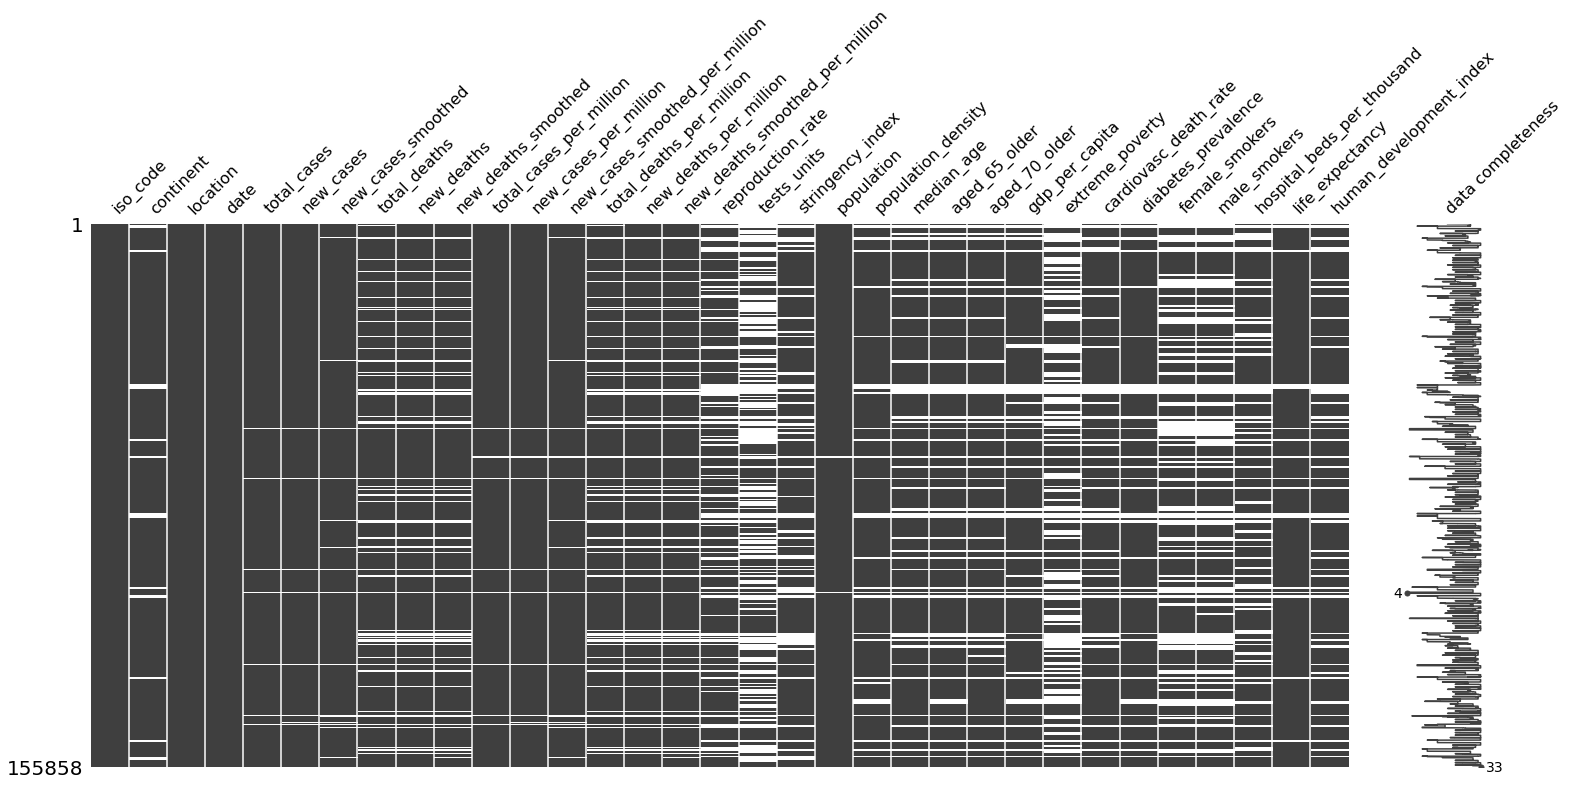

In [6]:
# Matrix plot
msno.matrix(data, labels=data.columns.any())
plt.show()

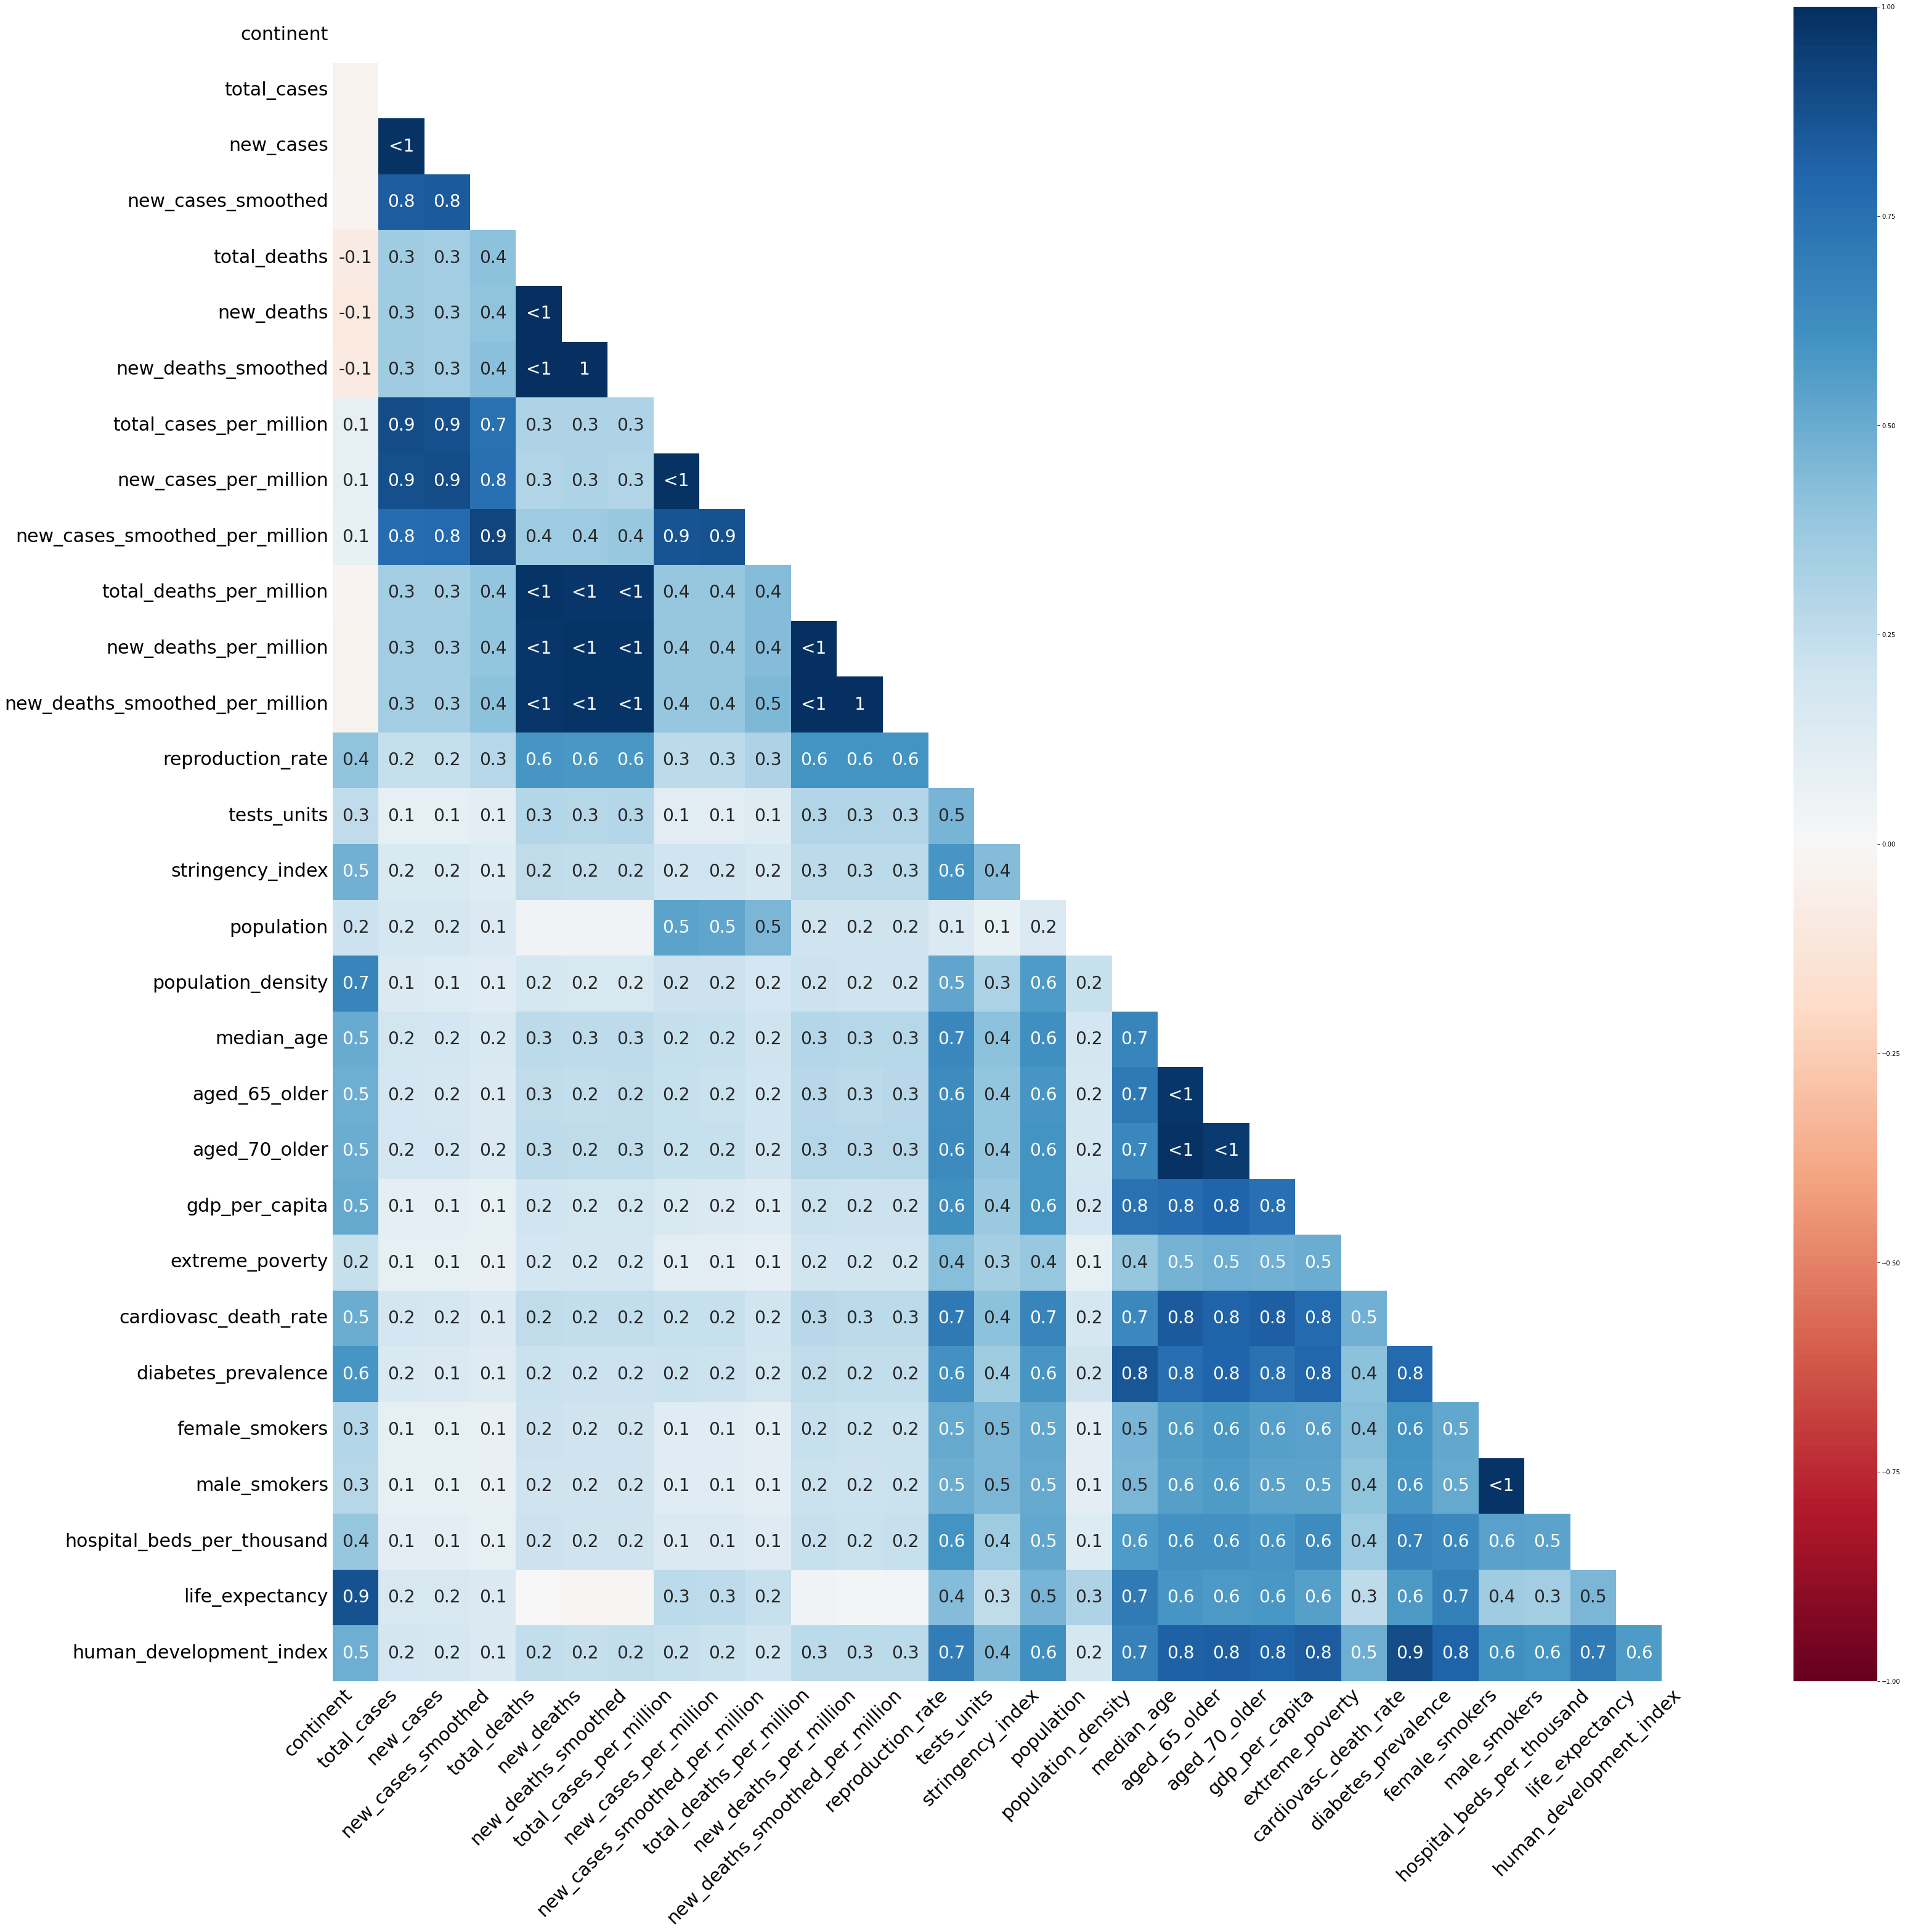

In [7]:
# Heatmap for correlation of null data between variables
msno.heatmap(data,figsize=(50,50), fontsize=30)
plt.show()

In [8]:
data.nunique()

iso_code                              238
continent                               6
location                              238
date                                  750
total_cases                         83265
new_cases                           19751
new_cases_smoothed                  36645
total_deaths                        32935
new_deaths                           4400
new_deaths_smoothed                 10073
total_cases_per_million            113880
new_cases_per_million               61975
new_cases_smoothed_per_million      71143
total_deaths_per_million            72692
new_deaths_per_million               9242
new_deaths_smoothed_per_million     10782
reproduction_rate                     385
tests_units                             4
stringency_index                      181
population                            236
population_density                    208
median_age                            136
aged_65_older                         188
aged_70_older                     

In [9]:
numerical_columns = []
categorical_columns = []
for column in data.columns:
    if data[column].dtype == float:
        numerical_columns.append(column)
    else:
        categorical_columns.append(column)

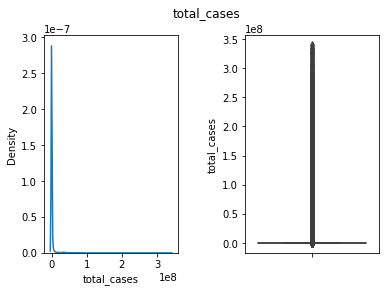

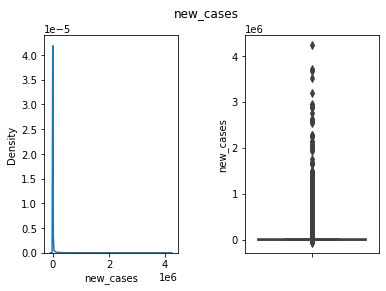

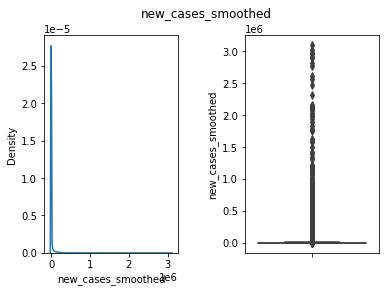

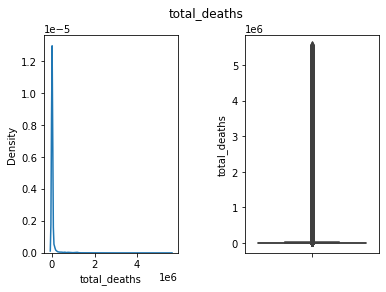

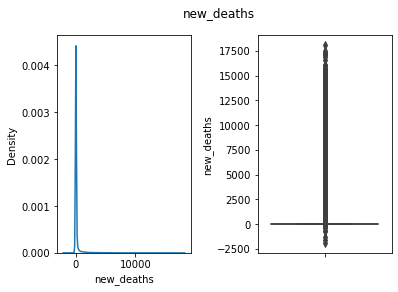

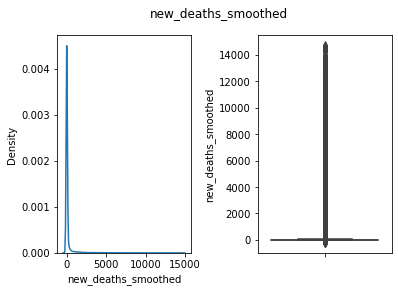

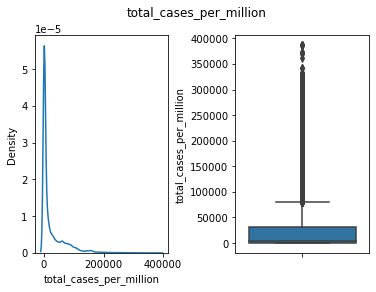

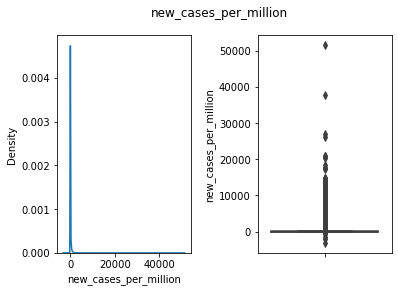

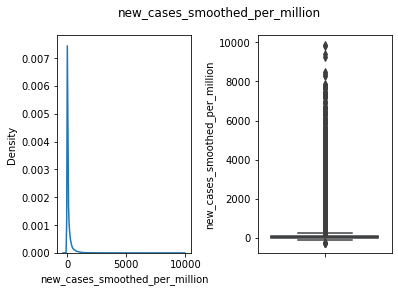

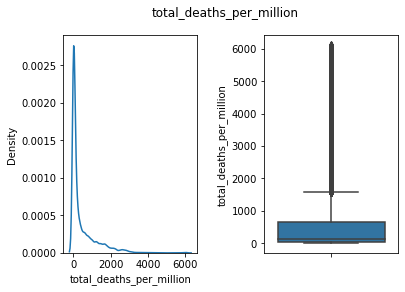

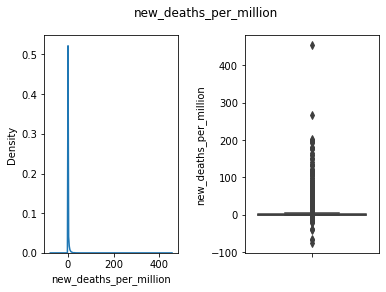

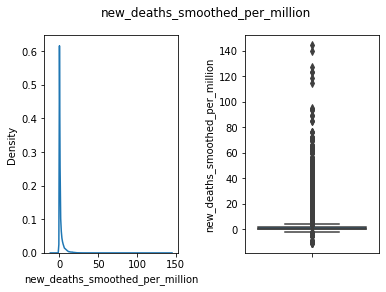

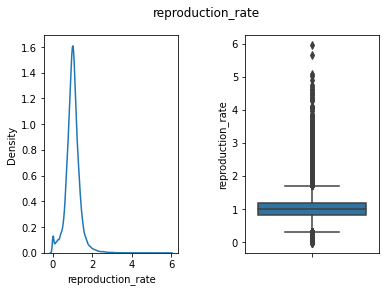

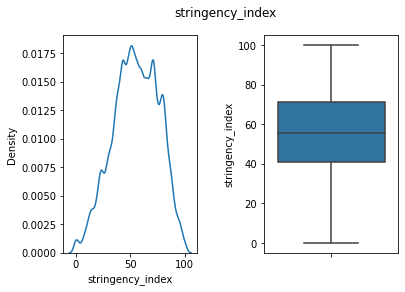

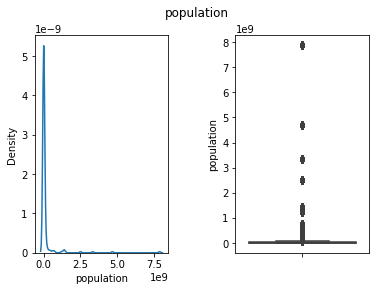

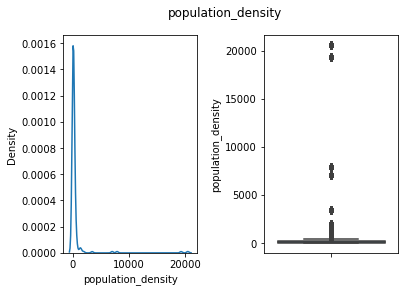

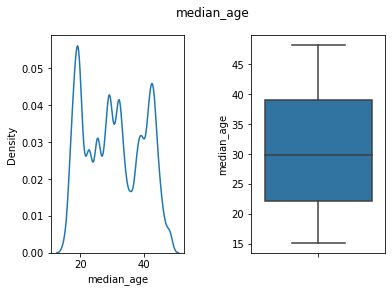

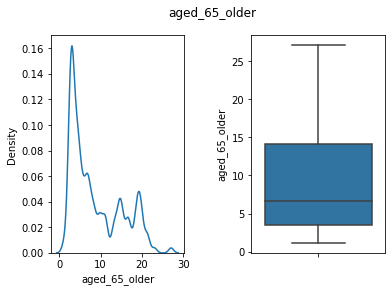

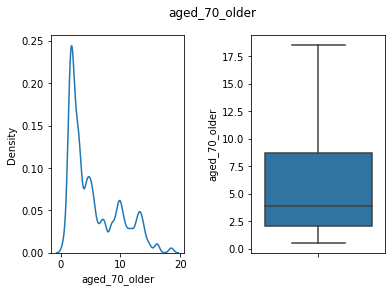

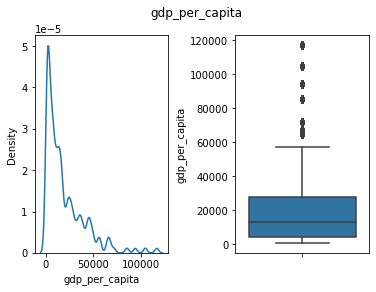

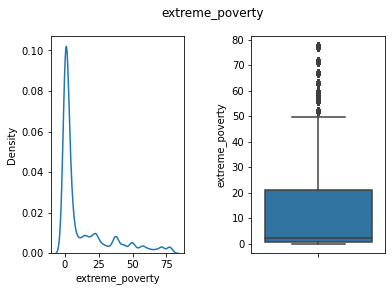

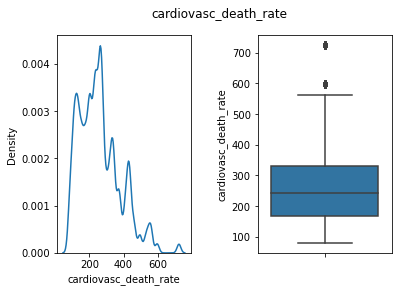

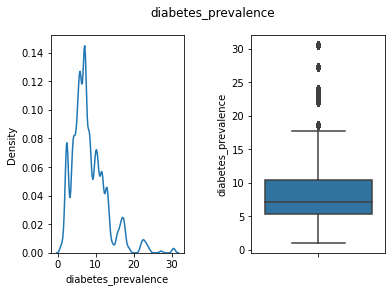

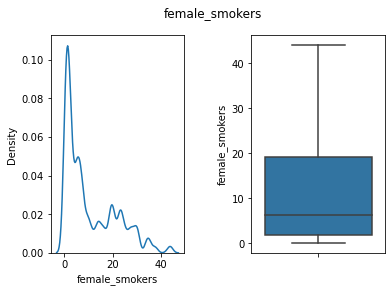

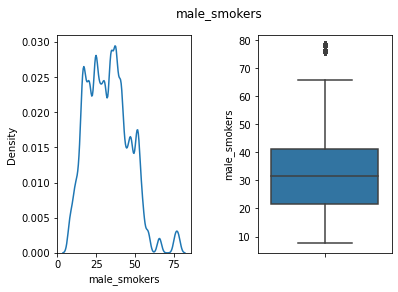

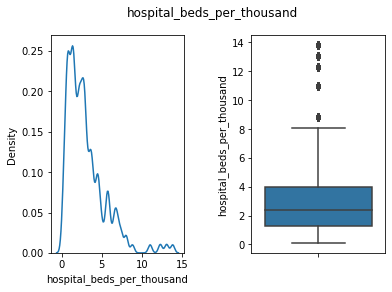

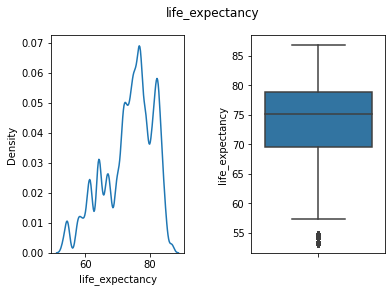

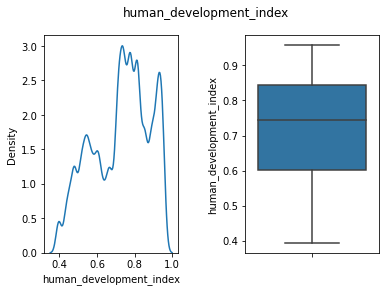

In [10]:
for column in numerical_columns:
    f, ax = plt.subplots(1,2)
    sns.kdeplot(data=data, x=column,ax=ax[0])
    sns.boxplot(data=data, y=column,ax=ax[1])
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle(column)
    plt.show()

## Mean Imputation

Missing values are handled by replacing missing values with mean of a given variable.

Assumption: Data missing is completely at random (not dependent on other features)

Advantages: Easy to implement

Disadvantages: Distorts variance and correlation of original data

Variable types: Continuous quantitative variables that are fairly symmetrical (skewness between -0.5 and 0.5)

In [11]:
# Checking skewness and variance of variable
print(f"Skewness of variable before mean imputation: {data['stringency_index'].skew()}")
print(f"Variance of variable before mean imputation: {data['stringency_index'].var()}")

Skewness of variable before mean imputation: -0.2064969660201239
Variance of variable before mean imputation: 423.041373202988


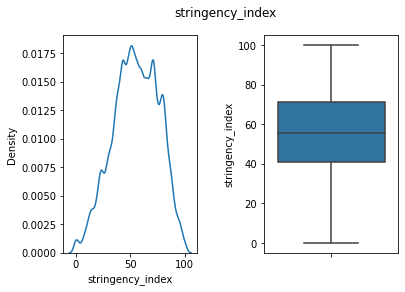

In [12]:
# Before mean imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='stringency_index',ax=ax[0])
sns.boxplot(data=data, y='stringency_index',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('stringency_index')
plt.show()

In [13]:
# Filling missing values with mean of variable
imputer = fei.MeanMedianImputer('mean')
data[['stringency_index']] = imputer.fit_transform(data[['stringency_index']])

In [14]:
# Checking skewness and variance of variable
print(f"Skewness of variable after mean imputation: {data['stringency_index'].skew()}")
print(f"Variance of variable after mean imputation: {data['stringency_index'].var()}")

Skewness of variable after mean imputation: -0.23316592113342618
Variance of variable after mean imputation: 331.8004551806343


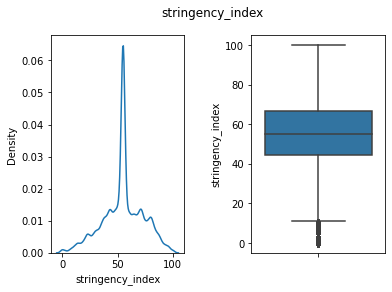

In [15]:
# After mean imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='stringency_index',ax=ax[0])
sns.boxplot(data=data, y='stringency_index',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('stringency_index')
plt.show()

## Median Imputation

Missing values are handled by replacing missing values with median of a given variable.

Assumption: Data missing is completely at random (not dependent on other features)

Advantages: Easy to implement

Disadvantages: Distorts variance and correlation of original data (smaller impact compared to mean imputation method)

Variable types:
- Discrete quantitative variables
- Continuous quantitative variables with moderate to large skewness (less than -0.5 or more than 0.5)

In [16]:
# Checking skewness and variance of variable
print(f"Skewness of variable before median imputation: {data['total_cases'].skew()}")
print(f"Variance of variable before median imputation: {data['total_cases'].var()}")

Skewness of variable before median imputation: 12.01954875780744
Variance of variable before median imputation: 171390005053283.28


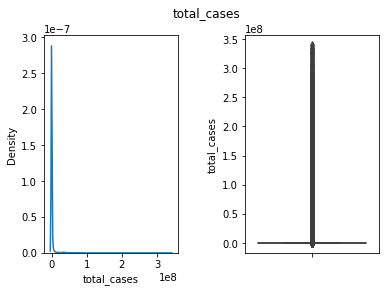

In [17]:
# Before median imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='total_cases',ax=ax[0])
sns.boxplot(data=data, y='total_cases',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('total_cases')
plt.show()

In [18]:
# Filling missing values with median of variable
imputer = fei.MeanMedianImputer('median')
data[['total_cases']] = imputer.fit_transform(data[['total_cases']])

In [19]:
# Checking skewness and variance of variable
print(f"Skewness of variable after median imputation: {data['total_cases'].skew()}")
print(f"Variance of variable after median imputation: {data['total_cases'].var()}")

Skewness of variable after median imputation: 12.13007406602974
Variance of variable after median imputation: 168362955292050.5


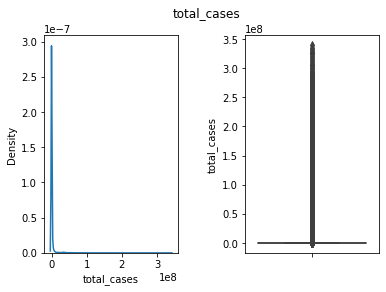

In [20]:
# After median imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='total_cases',ax=ax[0])
sns.boxplot(data=data, y='total_cases',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('total_cases')
plt.show()

## Random Sample Imputation

Missing values are handled by replacing missing values from a random sample.

Assumption: Data missing is completely at random (not dependent on other features)

Advantages: 
- Easy to implement
- Preserves original distribution of data
- Less distortion of variance

Disadvantages: Depends on condition that randomness works in a given problem.

Variable types:
- Quantitative variables
- Categorical variables

In [21]:
# Checking skewness and variance of variable
print(f"Skewness of variable before median imputation: {data['life_expectancy'].skew()}")
print(f"Variance of variable before median imputation: {data['life_expectancy'].var()}")

Skewness of variable before median imputation: -0.6602346799655491
Variance of variable before median imputation: 56.20612288529809


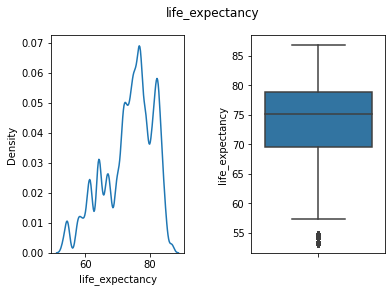

In [22]:
# Before random sample imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='life_expectancy',ax=ax[0])
sns.boxplot(data=data, y='life_expectancy',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('life_expectancy')
plt.show()

In [23]:
# Using random sample imputer
rsi = fei.RandomSampleImputer()
data[['life_expectancy']] = rsi.fit_transform(data[['life_expectancy']])

In [24]:
# Checking skewness and variance of variable
print(f"Skewness of variable after random sample imputation: {data['life_expectancy'].skew()}")
print(f"Variance of variable after random sample imputation: {data['life_expectancy'].var()}")

Skewness of variable after random sample imputation: -0.660546936306917
Variance of variable after random sample imputation: 56.15755778202905


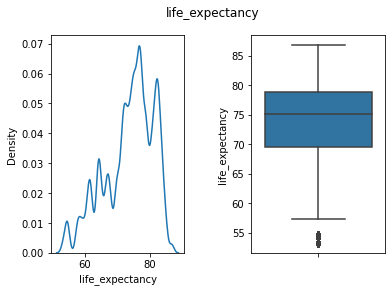

In [25]:
# After random sample imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='life_expectancy',ax=ax[0])
sns.boxplot(data=data, y='life_expectancy',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('life_expectancy')
plt.show()

## Missing Data Indicator

Missing values are handled by adding additional feature to indicate if data is missing or not

Assumption: Data missing is not at random.

Advantages: 
- Easy to implement
- Captures importance of missing data

Disadvantages: Creates additional features, which may cause curse of dimensionality for datasets with many variables having missing values.

Variable types:
- Quantitative variables
- Categorical variables

Note that missing data indicator can be used together with other imputation methods that do not capture importance of missing data.

In [26]:
ami = fei.AddMissingIndicator()
data['new_cases_na'] = ami.fit_transform(data[['new_cases']]).drop(['new_cases'],axis=1)

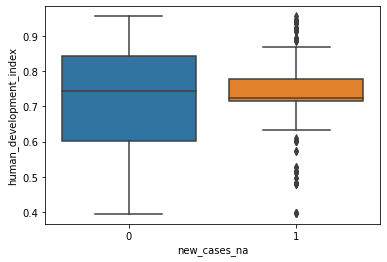

In [27]:
sns.boxplot(data = data, y= 'human_development_index', x='new_cases_na')
plt.show()

## End Tail Imputer

Missing values are handled by replacing missing values by extreme end of variable distribution (either based on mean + standard deviation or interquartile range)

Assumption: Data missing is not at random.

Advantages:
- Easy to implement
- Captures importance of missing data

Disadvantages:
- Distorts original distribution of variable
- Masking predictive power of original variable
- Mask true outliers for large null values
- Replaced null values may be outliers for small null values

Variable types: Continuous quantitative variables

In [28]:
# Checking skewness and variance of variable
print(f"Skewness of variable before end tail imputation: {data['diabetes_prevalence'].skew()}")
print(f"Variance of variable before end tail imputation: {data['diabetes_prevalence'].var()}")

Skewness of variable before end tail imputation: 1.3875233861438425
Variance of variable before end tail imputation: 20.142035037577752


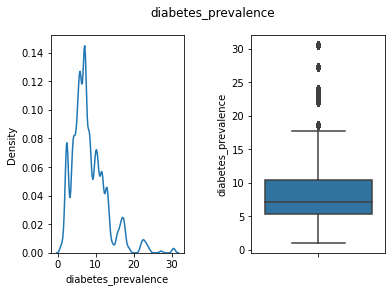

In [29]:
# Before end tail imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='diabetes_prevalence',ax=ax[0])
sns.boxplot(data=data, y='diabetes_prevalence',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('diabetes_prevalence')
plt.show()

In [30]:
eti = fei.EndTailImputer(imputation_method='iqr', fold=3)
data[['diabetes_prevalence']] = eti.fit_transform(data[['diabetes_prevalence']])

Note that iqr method is used for non-gaussian distribution, while gaussian method is used for gaussian distribution

In [31]:
# Checking skewness and variance of variable
print(f"Skewness of variable after end tail imputation: {data['diabetes_prevalence'].skew()}")
print(f"Variance of variable after end tail imputation: {data['diabetes_prevalence'].var()}")

Skewness of variable after end tail imputation: 1.150257632565152
Variance of variable after end tail imputation: 53.25958323361012


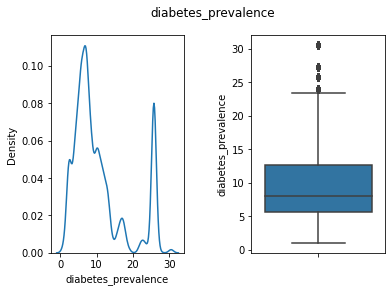

In [32]:
# After end tail imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='diabetes_prevalence',ax=ax[0])
sns.boxplot(data=data, y='diabetes_prevalence',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('diabetes_prevalence')
plt.show()

## Arbitrary Value Imputation

Missing data is handled by replacing missing data with an arbitrary value that is different from mean, mode, median and not in the range of normal values.

Assumption: Data missing is not at random.

Advantages:
- Easy to implement
- Captures importance of missing data

Disadvantages:
- Distorts original distribution of variable
- Masking predictive power of original variable
- Difficult to decide value to use
- Create outliers if the arbitrary value is at the end of the distribution

Variable types: Quantitative variables


In [33]:
# Checking skewness and variance of variable
print(f"Skewness of variable before arbitrary value imputation: {data['extreme_poverty'].skew()}")
print(f"Variance of variable before arbitrary value imputation: {data['extreme_poverty'].var()}")

Skewness of variable before arbitrary value imputation: 1.6248690000199755
Variance of variable before arbitrary value imputation: 400.37947571467623


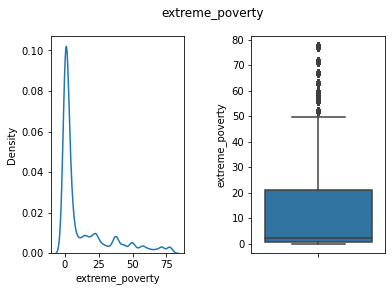

In [34]:
# Before arbitrary value imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='extreme_poverty',ax=ax[0])
sns.boxplot(data=data, y='extreme_poverty',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('extreme_poverty')
plt.show()

In [35]:
ani = fei.ArbitraryNumberImputer(20)
data[['extreme_poverty']] = ani.fit_transform(data[['extreme_poverty']])

In [36]:
# Checking skewness and variance of variable
print(f"Skewness of variable before arbitrary value imputation: {data['extreme_poverty'].skew()}")
print(f"Variance of variable before arbitrary value imputation: {data['extreme_poverty'].var()}")

Skewness of variable before arbitrary value imputation: 1.5000552551804014
Variance of variable before arbitrary value imputation: 230.25106121941434


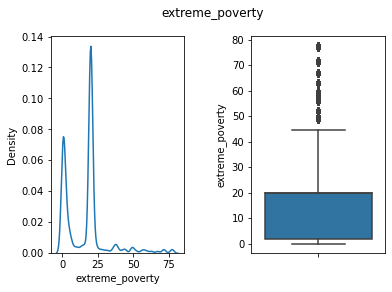

In [37]:
# After arbitrary value imputation
f, ax = plt.subplots(1,2)
sns.kdeplot(data=data, x='extreme_poverty',ax=ax[0])
sns.boxplot(data=data, y='extreme_poverty',ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.suptitle('extreme_poverty')
plt.show()

## Frequent Category Imputation

Missing data is handled by replacing missing values by most frequent category.

Assumption: 
- Data missing is at random.
- High probability that missing data looks like the majority of the data.

Advantages: Easy to implement

Disadvantages:
- Most frequent labels may be over represented for large number of null values
- Distorts relation of the most frequent labels

Variable types: Categorical variables with small proportion of null values (Not more than 5 to 6%)

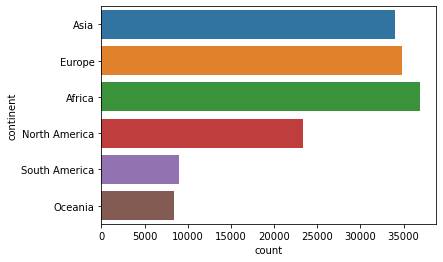

In [38]:
# Before frequent category imputation
sns.countplot(data=data, y='continent')
plt.show()

In [39]:
catimputer = fei.CategoricalImputer(imputation_method='frequent')
data[['continent']] = catimputer.fit_transform(data[['continent']])

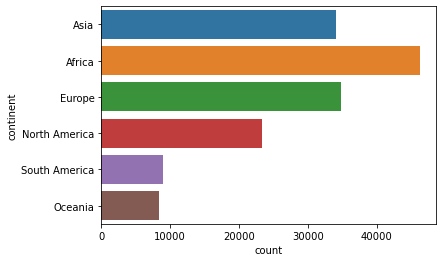

In [40]:
# After frequent category imputation
sns.countplot(data=data, y='continent')
plt.show()

## Missing Category Imputation

Missing data is handled by replacing missing values by a new category.

Assumption: No assumptions

Advantages: 
- Easy to implement
- Does not distort relation of most frequent label

Disadvantages:
- Not suitable for missing values with high frequency

Variable types: Categorical variables with small proportion of null values

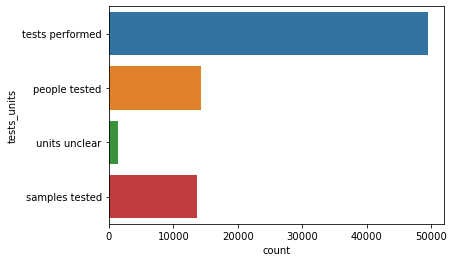

In [41]:
# Before missing category imputation
sns.countplot(data=data, y='tests_units')
plt.show()

In [42]:
catimputer = fei.CategoricalImputer(imputation_method='missing', fill_value='Missing')
data[['tests_units']] = catimputer.fit_transform(data[['tests_units']])

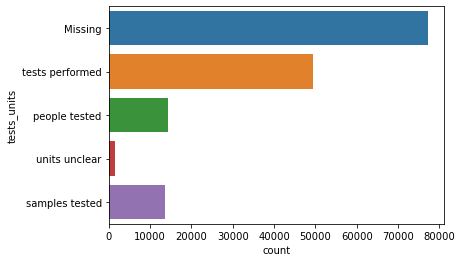

In [43]:
# After missing category imputation
sns.countplot(data=data, y='tests_units')
plt.show()

## Iterative Imputation

Missing data is handled by iteratively modelling each feature with missing values (target) as a function of other features to make predictions as replacement of missing data by utilizing regression model.

Assumptions: Data missing is not completely at random.

Advantages:
- Suitable for variables with many missing values
- Usually provides better performance than mean/median/mode imputation

Disadvantages:
- Computationally expensive
- Can be slow for large datasets
- Further hyperparameter tuning required

Variable types: Continuous quantitative variables

Note that iterative imputer in sklearn is derived from "Multiple Imputation by Chained Equations (MICE) method"

In [44]:
data = pd.read_csv('owid-covid-data.csv')

In [45]:
# Distribution of variables before Iterative Imputation
for column in numerical_columns:
    print(f"Skewness of {column} before iterative imputation: {data[column].skew()}")
    print(f"Variance of {column} before iterative imputation: {data[column].var()}")
    print('')

Skewness of total_cases before iterative imputation: 12.01954875780744
Variance of total_cases before iterative imputation: 171390005053283.28

Skewness of new_cases before iterative imputation: 22.24143007659945
Variance of new_cases before iterative imputation: 4043521928.0967135

Skewness of new_cases_smoothed before iterative imputation: 19.490673763807294
Variance of new_cases_smoothed before iterative imputation: 3446754326.3108654

Skewness of total_deaths before iterative imputation: 10.760087869287304
Variance of total_deaths before iterative imputation: 79888631717.33641

Skewness of new_deaths before iterative imputation: 8.984707397031013
Variance of new_deaths before iterative imputation: 686928.5078434629

Skewness of new_deaths_smoothed before iterative imputation: 8.638112231352634
Variance of new_deaths_smoothed before iterative imputation: 654645.1560141863

Skewness of total_cases_per_million before iterative imputation: 2.3615806907197854
Variance of total_cases_per

In [46]:
# Dict of hyperparameters for iterative imputer
IterativeImputer().get_params()

{'add_indicator': False,
 'estimator': None,
 'imputation_order': 'ascending',
 'initial_strategy': 'mean',
 'max_iter': 10,
 'max_value': inf,
 'min_value': -inf,
 'missing_values': nan,
 'n_nearest_features': None,
 'random_state': None,
 'sample_posterior': False,
 'skip_complete': False,
 'tol': 0.001,
 'verbose': 0}

In [47]:
imputer = IterativeImputer(max_iter = 100, verbose=1)
data[numerical_columns] = pd.DataFrame(imputer.fit_transform(data[numerical_columns]), columns = numerical_columns)

[IterativeImputer] Completing matrix with shape (155858, 28)
[IterativeImputer] Change: 116303182.23050623, scaled tolerance: 7874965.73 
[IterativeImputer] Change: 52514075.30006747, scaled tolerance: 7874965.73 
[IterativeImputer] Change: 4029595.598013334, scaled tolerance: 7874965.73 
[IterativeImputer] Early stopping criterion reached.


In [48]:
data[numerical_columns].isnull().sum()

total_cases                        0
new_cases                          0
new_cases_smoothed                 0
total_deaths                       0
new_deaths                         0
new_deaths_smoothed                0
total_cases_per_million            0
new_cases_per_million              0
new_cases_smoothed_per_million     0
total_deaths_per_million           0
new_deaths_per_million             0
new_deaths_smoothed_per_million    0
reproduction_rate                  0
stringency_index                   0
population                         0
population_density                 0
median_age                         0
aged_65_older                      0
aged_70_older                      0
gdp_per_capita                     0
extreme_poverty                    0
cardiovasc_death_rate              0
diabetes_prevalence                0
female_smokers                     0
male_smokers                       0
hospital_beds_per_thousand         0
life_expectancy                    0
h

In [49]:
# Distribution of variables after Iterative Imputation
for column in numerical_columns:
    print(f"Skewness of {column} after iterative imputation: {data[column].skew()}")
    print(f"Variance of {column} after iterative imputation: {data[column].var()}")
    print('')

Skewness of total_cases after iterative imputation: 12.131041447890642
Variance of total_cases after iterative imputation: 168294768157747.28

Skewness of new_cases after iterative imputation: 22.44972923997146
Variance of new_cases after iterative imputation: 3968797656.4377346

Skewness of new_cases_smoothed after iterative imputation: 19.745855746006267
Variance of new_cases_smoothed after iterative imputation: 3358316345.1977854

Skewness of total_deaths after iterative imputation: 11.516070764916375
Variance of total_deaths after iterative imputation: 69740977257.90993

Skewness of new_deaths after iterative imputation: 9.622680261717077
Variance of new_deaths after iterative imputation: 598628.2614326946

Skewness of new_deaths_smoothed after iterative imputation: 9.259836400351453
Variance of new_deaths_smoothed after iterative imputation: 569985.7887311311

Skewness of total_cases_per_million after iterative imputation: 2.3820765831253157
Variance of total_cases_per_million aft

## KNN Imputation

Missing data is handled by replacing every missing value by the mean of the n_neighbors non-null samples found in proximity to a given sample using K nearest neighbors (KNN) algorithm.

Assumptions: Data missing is not completely at random.

Advantages: Usually provides better performance than mean/median/mode imputation

Disadvantages:
- Computationally expensive
- Sensitive to outliers
- Further hyperparameter tuning required

Variable types: Continuous quantitative variables

In [50]:
# Dict of hyperparameters for KNN imputer
KNNImputer().get_params()

{'add_indicator': False,
 'copy': True,
 'metric': 'nan_euclidean',
 'missing_values': nan,
 'n_neighbors': 5,
 'weights': 'uniform'}

In [51]:
# Coding below not implemented due to very large time complexity for this specific dataset
# imputer = KNNImputer(n_neighbors=3)
# data[numerical_columns] = imputer.fit_transform(data[numerical_columns])

## Missing Forest Imputation

Missing data is handled by first replacing every missing value using mean/median imputation, followed by marking records with missing values as prediction for random forest model iteratively.

Assumptions: Data missing is not completely at random.

Advantages: 
- Usually provides better performance than mean/median/mode imputation
- Robust to outliers and multicollinearity
- Not prone to curse of dimensionality

Disadvantages:
- Computationally expensive
- Not suitable for small datasets
- Algorithm that needs to be run every time new missing data is imputed

Variable types: 
- Continuous quantitative variables
- Categorical variables after label encoding

In [52]:
data = pd.read_csv('owid-covid-data.csv')

In [53]:
# Distribution of variables before MissForest Imputation
for column in numerical_columns:
    print(f"Skewness of {column} before missing forest imputation: {data[column].skew()}")
    print(f"Variance of {column} before missing forest imputation: {data[column].var()}")
    print('')

Skewness of total_cases before missing forest imputation: 12.01954875780744
Variance of total_cases before missing forest imputation: 171390005053283.28

Skewness of new_cases before missing forest imputation: 22.24143007659945
Variance of new_cases before missing forest imputation: 4043521928.0967135

Skewness of new_cases_smoothed before missing forest imputation: 19.490673763807294
Variance of new_cases_smoothed before missing forest imputation: 3446754326.3108654

Skewness of total_deaths before missing forest imputation: 10.760087869287304
Variance of total_deaths before missing forest imputation: 79888631717.33641

Skewness of new_deaths before missing forest imputation: 8.984707397031013
Variance of new_deaths before missing forest imputation: 686928.5078434629

Skewness of new_deaths_smoothed before missing forest imputation: 8.638112231352634
Variance of new_deaths_smoothed before missing forest imputation: 654645.1560141863

Skewness of total_cases_per_million before missing 

In [54]:
# Dict of hyperparameters for MissForest imputer
MissForest().get_params()

{'bootstrap': True,
 'class_weight': None,
 'copy': True,
 'criterion': ('mse', 'gini'),
 'decreasing': False,
 'max_depth': None,
 'max_features': 'auto',
 'max_iter': 10,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'missing_values': nan,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
imputer = MissForest(verbose=1,criterion=('squared_error','gini'))
data[numerical_columns] = pd.DataFrame(imputer.fit_transform(data[numerical_columns]), columns = numerical_columns)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.2s
[Parall

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

Iteration: 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parall

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

Iteration: 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parall

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.

Iteration: 2


In [56]:
# Distribution of variables after MissForest Imputation
for column in numerical_columns:
    print(f"Skewness of {column} after missing forest imputation: {data[column].skew()}")
    print(f"Variance of {column} after missing forest imputation: {data[column].var()}")
    print('')

Skewness of total_cases after missing forest imputation: 12.130134526550023
Variance of total_cases after missing forest imputation: 168308468817484.78

Skewness of new_cases after missing forest imputation: 22.45045327956258
Variance of new_cases after missing forest imputation: 3969184820.632581

Skewness of new_cases_smoothed after missing forest imputation: 19.74685343692447
Variance of new_cases_smoothed after missing forest imputation: 3358532909.233784

Skewness of total_deaths after missing forest imputation: 11.53213451556333
Variance of total_deaths after missing forest imputation: 69828448039.53905

Skewness of new_deaths after missing forest imputation: 9.132264783373877
Variance of new_deaths after missing forest imputation: 616086.9334723272

Skewness of new_deaths_smoothed after missing forest imputation: 9.092108266552058
Variance of new_deaths_smoothed after missing forest imputation: 575197.209517462

Skewness of total_cases_per_million after missing forest imputation

## Complete Case Analysis (List-wise deletion)

Missing data is handled by simply removing records with any missing values.

Assumptions: Data missing is at random

Advantages:
- Easy to implement.
- No Data manipulation required.

Disadvantages:
- Deleted data can be informative.
- Can lead to the deletion of a large part of the data.
- Can create a bias in the dataset, if a large amount of a particular type of variable is deleted from it.

Variable types: All variable types with small proportion of null values (Not more than 5 to 6%)

## Dropping Columns

Missing data is handled by removing columns with large number of null values

Assumptions: No assumptions

Advantages:
- Easy to implement
- May improve model performance for features that are identified to be insignifcant

Disadvantages:
- Deleted data can be informative
- May worsen model performance for features that are identified to be significant

Variable types: All variable types with very large proportion of null values (at least 80%)

Note that this approach is generally not recommended, unless if the feature is insignificant in the first place.